In [1]:
!pip install -U torchtext==0.4.0
!pip install -U transformers

In [2]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
from torchtext.data import Field, Dataset, TabularDataset, BucketIterator, Iterator
# torchtext.legacy
# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
source_folder = '/content/drive/MyDrive/Colab Notebooks/education project/data'
destination_folder = '/content/drive/MyDrive/Colab Notebooks/education project/results'

cuda:0


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 512
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)



label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('title', text_field), ('short_description', text_field), ('need_statement', text_field),
          ('essay', text_field),('text', text_field),('label', label_field)]

# TabularDataset

train, validation, test = TabularDataset.splits(path=source_folder, 
                                                train='train_inc.csv',validation='val_inc.csv', test='test_inc.csv',
                                                format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=10, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(validation, batch_size=10, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=10, device=device, train=False, shuffle=False, sort=False)


In [5]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        

        return loss, text_fea

In [6]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [7]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path =destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    # training loop
    model.train()
    for epoch in range(num_epochs):
        for i in train_loader:
            labels = i.label.type(torch.LongTensor)           
            labels = labels.to(device)
            text = i.text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for i in valid_loader:
                        labels = i.label.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = i.text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [157/1570], Train Loss: 0.6718, Valid Loss: 0.6256
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/education project/results/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/education project/results/metrics.pt
Epoch [1/5], Step [314/1570], Train Loss: 0.5464, Valid Loss: 0.5132
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/education project/results/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/education project/results/metrics.pt
Epoch [2/5], Step [471/1570], Train Loss: 0.5170, Valid Loss: 0.5571
Epoch [2/5], Step [628/1570], Train Loss: 0.4298, Valid Loss: 0.4867
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/education project/results/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/education project/results/metrics.pt
Epoch [3/5], Step [785/1570], Train Loss: 0.3899, Valid Loss: 0.4778
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/education project/results/model.p

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/education project/results/metrics.pt


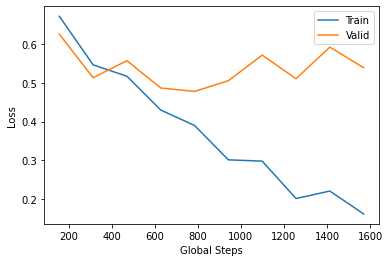

In [8]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/education project/results/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7965    0.8930    0.8420       355
           0     0.8613    0.7445    0.7986       317

    accuracy                         0.8229       672
   macro avg     0.8289    0.8187    0.8203       672
weighted avg     0.8271    0.8229    0.8215       672



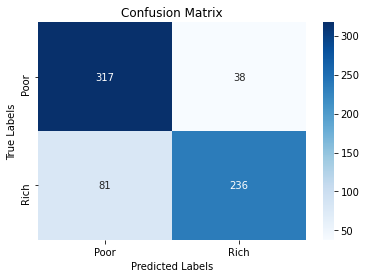

In [10]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for i in test_loader:
                labels = i.label.type(torch.LongTensor)           
                labels = labels.to(device)
                text = i.text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Poor', 'Rich'])
    ax.yaxis.set_ticklabels(['Poor', 'Rich'])
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)